# "Продвинутый Python". Магистерская программа ВШЭ. ДЗ1

## Выполнил Эдуард Аюнц, МФТиАД18

**Цель курса**: получить предстваление о принципах создания сервисов и реализовать их в собственном ML-проекте.

**Ключевые навыки**: ООП, Django, luigi

### Домашнее задание №0 [0.2 балла]

**Условие**:

Функция `delete_zeros_from_array` принимает на вход массив целых чисел из промежутка [0; 5] и удалает из него все _нули_. Алгоритм должен иметь сложность `O(N)`, где N - длина массива, и использовать `O(1)` дополнительной памяти.

Построить **графики** зависимости времени работы алгоритма от количества элементов в нем. 

**Примечания**:

1) Для наглядности лучше генерить массивы, в которых количество удаляемых элементов **больше трети** от всех элементов.

2) В такой постановке можно проверить, как разработчик выбирает имена переменных и думает ли о функции глобально. Например, следующим вопросом было бы "А что если хотим удалять единицы?"

In [1]:
from random import randint
from itertools import permutations
import numpy as np
import pandas as pd
import time
import random
import sys
sys.setrecursionlimit(50000)
import gc
import string
from math import ceil, floor, sqrt
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from functools import partial, lru_cache
%load_ext memory_profiler

In [2]:
# Not bad way
def delete_elements_from_array(array, element):
    """
        This function deletes all elements that equal to element from array. 
        
        :param array: Input array
        :type array: list
        :param element: Element that must be deleted from array
        :type element: int
        
        :returns: New array without element with the other elements in the same order
        :rtype: list
    """

    offset = 0    
    for i in range(len(array)):
        if array[i] == element:
            start_id = i + offset + 1
 
            swapped = False
            for j in range(start_id, len(array)):
                if array[j] != element:
                    array[i], array[j] = array[j], array[i]
                    offset = j - i - 1
 
                    swapped = True
                    break
 
            if not swapped:
                del array[i:]
                break
 
    return array    

    delete_zeros_from_array = partial(delete_elements_from_array, element=0)

In [3]:
delete_elements_from_array([1,2,3,3,453423,12123,52,0,7,5,23,0,0,1], 0)

[1, 2, 3, 3, 453423, 12123, 52, 7, 5, 23, 1]

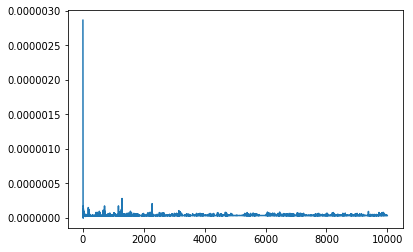

In [4]:
lst = [1]
times = []

for i in tqdm_notebook(range(10000)):
    lst.append(randint(-1,1))
    start_time = time.time()
    delete_elements_from_array(lst, 0)
    times.append(time.time()-start_time) #время нормализуем на длину списка
    
plt.plot([j/(1+i) for i,j in enumerate(times)])

### Комментарий 
Видим, что алгоритм работает O(n) по времени (время выполнения деленное на длину входного листа - константа)

### Домашнее задание №1 [0.05 балла]

**Условие**:

Написать функцию (-и), которая принимает на вход 3 комплексных числа и выводит минимальное из них по модулю без использования функций min, max, sort и т.д.


**Комментарии**:

1) В процессе сдачи задания, можно будет получить дополнительные баллы

2) Код должен быть пригоден для промышленного использования

In [5]:
class Complex(object):
    def __init__(self, real, imag = 0.0):
        self.real = real
        self.imag = imag
        
    def __abs__(self):
        return sqrt(self.real ** 2 + self.imag ** 2)
    
    def __str__(self):
        '''Returns complex number as a string'''    
        if str(self.imag)[0] == '-':
            return f"""{self.real}{self.imag}i"""
        else: return f"""{self.real}+{self.imag}i"""

def get_min(a, b, c):
    """
        This function returns the smallest one among 3 complex numbers
        
        :param array: Input array 
        :param element: Items to compare with  each other
        :type element: Complex
        
        :returns: The smallest by modulo complex number
        :rtype: Complex
    """
    if not all([isinstance(i, Complex) for i in [a, b, c]]):
        raise TypeError('a, b, c to be of Complex class objects')
    else:
        a_abs, b_abs,c_abs  = abs(a), abs(b), abs(c)
        if a_abs <= b_abs and a_abs <= c_abs: 
            return a
        elif b_abs <= a_abs and b_abs <= c_abs: return b
        else: return c

In [6]:
x = Complex(1,-22)
y = Complex(3,-52)
z = Complex(2,-2)
print(get_min(x,y,z))

2-2i


### Домашнее задание №2 [0.18 балла]

**Условие**:

Вы - банкомат, который работает по следующей схеме: считывает номер вставленной в него карты, парсит его на 4 равные части и генерирует 4 числа Фибоначчи с номерами, соответствущими распаршенным частям. Затем генерирует числа из всевозможных перестановок полученных чисел Фибоначчи (конкатенацией).

Для каждого числа из полученного набора банкомат находит НОД с введеным пользователем паролем и возвращает медиану из полученных НОДов. 

**Комментарии**:

1) Поток клиентов большой, операции повторяющиеся - хорошо бы, чтобы со временем банкомат отвечал быстрее на запросы.

2) За неполное решение также дается часть баллов.

**Ключевые слова**: lru_cache, permutations, алгоритм Евклида

In [7]:
def plot_cumulative_mean(times):
    """
    Returns the total average time for each step of the runtime.
    E.g. if the function accelerates it's performance and has O(1) runtime complexity,
    then the plot will have downward slope  
    """
    pd.Series(times).cumsum().div(pd.Series(times).index.to_series(), axis=0).plot()

In [8]:
def get4random():
    return ''.join([str(random.randint(0,9)) for i in range(4)])

In [9]:
get4random()

'4826'

In [10]:
from math import ceil, floor
import numpy as np
from itertools import permutations
from decimal import *
getcontext().prec = 2

class Sberbank_bankomat:
    def __init__(self): 
        pass
    
    @lru_cache(maxsize=10000000000)    
    def fib(self, n):
        '''
        :param n: number of the Fibonacci number to return
        :return:  n-th Fibonacci number
        '''        
        def pow(x, n):  
            if n < 2: return x
            else:
                y = pow(x, n // 2)
                y = y.dot(y)
                if n % 2: y = x.dot(y)
                return y
        F = pow(np.matrix([[1,1],[1,0]], dtype=object), n)
        return np.array(F).flatten()[1]

    def get_GCD(self, x, y):
        '''
        Euclid algorithm's implementation
        params: x, y 
        return: GCD(x, y)
        '''    
        while y > 0: x, y = y, x % y 
        return x     
    
    
    def check_inputs(self, card_number, pin):
        '''
        params: card_number and pin, both are ints
        return: nothing if all requiered conditions are met. ValueError otherwise
        '''
        
        if len(card_number) == 16 and len(pin) == 4 :
            pass            
        else:
            raise ValueError('Card number should be 16 digit number and PIN should have 4 digits')

        try:
            card_number, pin = int(card_number), int(pin)
            pass
        except:
            raise ValueError('Both card number and PIN should str but contain  only digits')
  
    
    def get_median_for_card(self, card_number, pin):
        '''
        
        Takes card number and PIN and returns median of the GCDs of all Fibbonaci number
        combinations from the card number.
        
        :param array: Input array
        :type array: 2 ints
        :param element: int
        :type element: int
        
        :returns: median of the  GCDs
        :rtype: Decimal (to prevent overflow)       
        '''
        self.check_inputs(card_number, pin)
        
        four_digits = [int(str(card_number)[i:i+4]) for i in  range(len(str(card_number))) if i%4==0]
        four_fibs = [str(self.fib(i)) for i in four_digits]
        perms = [int(''.join(i)) for i in permutations(four_fibs)]

        GCDs = sorted([self.get_GCD(i, int(pwd)) for i in perms])
        right, left = ceil(len(GCDs)/2), floor(len(GCDs)/2) # e.g. there are 15 digit cards,  so our median supports this

        return  Decimal((GCDs[right] + GCDs[left]))/Decimal(2)


In [11]:
card_number, pwd = ''.join([get4random() for i in range(4)]), get4random()
print(card_number, pwd)

9204597482529826 9000


In [12]:
bankomat  = Sberbank_bankomat()

In [13]:
bankomat.get_median_for_card(card_number, pwd)

Decimal('3')

In [14]:
%timeit bankomat.get_median_for_card(card_number, pwd)

6.76 ms ± 190 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%memit bankomat.get_median_for_card(card_number, pwd)

peak memory: 114.10 MiB, increment: -0.03 MiB


In [16]:
times = []
for i in tqdm_notebook(range(10000)):
    card_number, pwd = ''.join([get4random() for i in range(4)]), get4random()
    start_time = time.time()
    bankomat.get_median_for_card(card_number, pwd)
    times.append(time.time()- start_time)

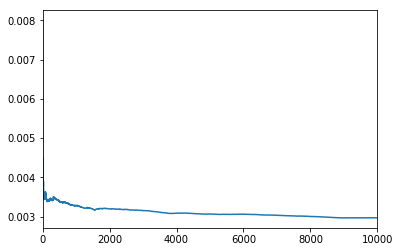

In [17]:
plot_cumulative_mean(times)

По графику видно, что накопленное среднее время падает с увеличением числа итераций - то есть кеширование действительно работает

### Домашнее задание №3 [0 - 0.1 балла]

**Условие:**
    
Сравнить скорость работы и потребление памяти list и deque.

**Комментарий:**

Количество баллов зависит от полноты сравнения.

In [18]:
from collections import deque

length = 1000
s = list(range(length))
d = deque(s)

#### Сначала проведем простое сравнение
Удаление из конца

In [19]:
%timeit s.pop(); s.append(None)
%memit s.pop(); s.append(None)

%timeit d.pop(); d.append(None)
%memit d.pop(); d.append(None)

115 ns ± 3.4 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
peak memory: 121.32 MiB, increment: -0.30 MiB
109 ns ± 2.72 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
peak memory: 121.32 MiB, increment: 0.00 MiB


Удаление из начала

In [20]:
%timeit s.pop(0); s.append(None)
%memit s.pop(0); s.append(None)

%timeit d.popleft(); d.append(None)
%memit d.popleft(); d.append(None)

236 ns ± 10.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
peak memory: 121.32 MiB, increment: 0.00 MiB
110 ns ± 2.97 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
peak memory: 121.32 MiB, increment: 0.00 MiB


Добавление элемента в начало

In [21]:
%timeit s.insert(0, None)
%timeit d.appendleft(None); 

%memit s.insert(0, None)
%memit d.appendleft(None)

The slowest run took 6.30 times longer than the fastest. This could mean that an intermediate result is being cached.
228 µs ± 119 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
64.7 ns ± 1.51 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
peak memory: 776.91 MiB, increment: 0.00 MiB
peak memory: 776.91 MiB, increment: 0.00 MiB


Добавление элемента в конец

In [22]:
%timeit s.append(None)
%timeit d.append(None); 

%memit s.append(None)
%memit d.append(None)

59.5 ns ± 1.37 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
64.1 ns ± 1.69 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
peak memory: 2044.02 MiB, increment: 0.00 MiB
peak memory: 2044.02 MiB, increment: 0.00 MiB


In [23]:
def get_runtimes(size, action = 'popleft'):
    l = list(range(size))
    d = deque(l)
    
    if action == 'popleft': 
        st = time.time()
        l.pop()
        l_time = time.time() - st
        
        st = time.time()
        d.popleft()
        d_time = time.time() - st
        
    elif action == 'popright': 
        st = time.time()
        l.pop()
        l_time = time.time() - st
        
        st = time.time()
        d.pop()
        d_time = time.time() - st        
    elif action == 'addleft': 
        st = time.time()
        l.insert(0,None)
        l_time = time.time() - st
        
        st = time.time()
        d.appendleft(None)
        d_time = time.time() - st
        
    elif action == 'addright': 
        st = time.time()
        l.append(None)
        l_time = time.time() - st
        
        st = time.time()
        d.append(None)
        d_time = time.time() - st   
    else:
        raise Exception('No such action')
    return (l_time, d_time )
        

In [24]:
def get_memories(size, action = 'popleft'):
    
    def pop_wo_return(l, right = True):
        if right: l.pop()
        else: l.pop(0)

    def real_append(l):
        l.append(1)            
    
    l = list(range(size))
    d = deque(l)
    
    if action == 'popleft': 
        l.pop()
        d.pop()                  
        
    elif action == 'popright': 
        l.pop(0)
        d.popleft()

    elif action == 'addleft': 
        l.insert(0, list(range(size)))
        d.appendleft(list(range(size)))
        
    elif action == 'addright': 
        l.append(list(range(size)))
        d.append(list(range(size)))

    else:
        raise ValueError('No such action')
    return (sys.getsizeof(l), sys.getsizeof(d) )

In [25]:
def get_plots(runtimes, memories, action):
    nrow=1
    ncol=2
    
    runtime_comparison = pd.DataFrame.from_dict(runtimes,orient = 'index')  
    runtime_comparison.columns = ['list, sec','deque, sec']
    
    memory_comparison = pd.DataFrame.from_dict(memories,orient = 'index')  
    memory_comparison.columns = ['list, MB','deque, MB']
    
    df_list = [runtime_comparison, memory_comparison]
    fig, axes = plt.subplots(nrow, ncol)

    count=0
    for r in range(nrow):
        for c in range(ncol):
            if count>0: name = 'Memory comparison' + ' ' + action
            else: name = 'Runtime comparison' + ' ' + action
            df_list[count].plot(ax=axes[c], title = name,figsize =(10,5))
            count=+1

In [26]:
def get_comparison(action, step = 5000):
    runtimes = {}
    memories = {}

    action = action
    for i in tqdm_notebook(range(1,500000, step)):
        runtimes[i] = get_runtimes(i,action)
        memories[i] = get_memories(i,action)
        gc.collect()
    get_plots(runtimes, memories, action)


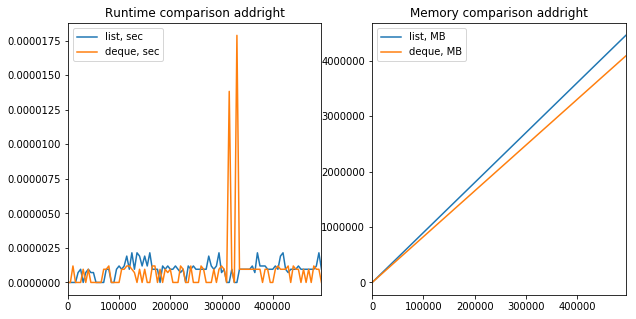

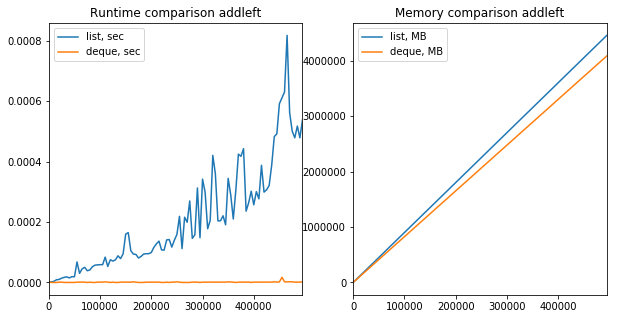

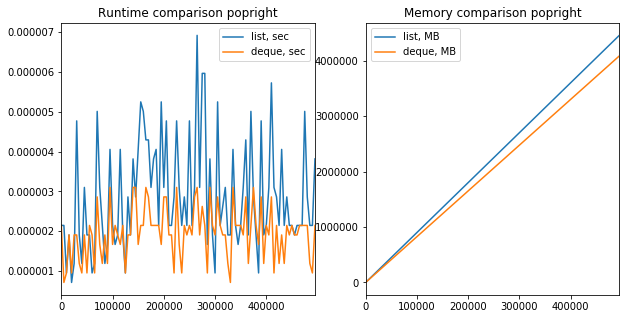

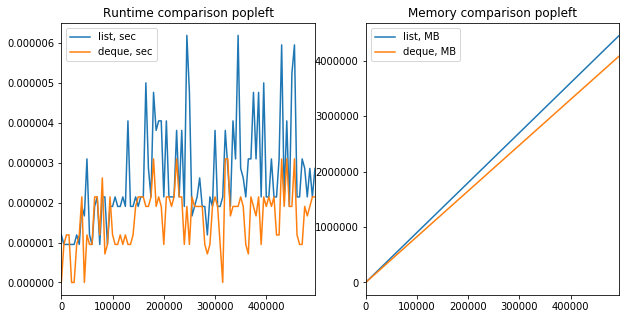

In [27]:
for action in ['addright', 'addleft', 'popright', 'popleft']:
    get_comparison(action)

#### Комментарий

Как видим, во всех проведенных сравнениях list выполняется дольше, однако при вставке в начале у list сложность возрастает  линейно а deque работает за O(1)

### Домашнее задание №4 [0 - 0.1 балла]

**Условие:**
    
Написать аналог permutations и провести сравнение скорости работы и потребления памяти.

**Комментарий:**

Количесвто баллов зависит от полноты сравнения.

In [28]:
from itertools import permutations
import string

In [29]:
def custom_permutations(array):
    array = tuple(array)
    '''Takes list of characters, returns generator with all permutations of the given list'''
    if len(array)>1:
        for i in range(len(array)):
            for x in custom_permutations(array[:i]+array[i+1:]): yield tuple(array[i])+ x
    else: yield array

In [30]:
def get_random_string(n): # функция возвращающая случайную строку заданной длины
    return ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(n))

In [31]:
random_string = get_random_string(8)
random_string

'QJEQDFCN'

In [32]:
len([i for i in custom_permutations(random_string)]), len([i for i in permutations(random_string)])

(40320, 40320)

In [33]:
perms  = list(permutations(random_string))
perms[:10]

[('Q', 'J', 'E', 'Q', 'D', 'F', 'C', 'N'),
 ('Q', 'J', 'E', 'Q', 'D', 'F', 'N', 'C'),
 ('Q', 'J', 'E', 'Q', 'D', 'C', 'F', 'N'),
 ('Q', 'J', 'E', 'Q', 'D', 'C', 'N', 'F'),
 ('Q', 'J', 'E', 'Q', 'D', 'N', 'F', 'C'),
 ('Q', 'J', 'E', 'Q', 'D', 'N', 'C', 'F'),
 ('Q', 'J', 'E', 'Q', 'F', 'D', 'C', 'N'),
 ('Q', 'J', 'E', 'Q', 'F', 'D', 'N', 'C'),
 ('Q', 'J', 'E', 'Q', 'F', 'C', 'D', 'N'),
 ('Q', 'J', 'E', 'Q', 'F', 'C', 'N', 'D')]

In [34]:
perms  = list(custom_permutations(random_string))
perms[:10]

[('Q', 'J', 'E', 'Q', 'D', 'F', 'C', 'N'),
 ('Q', 'J', 'E', 'Q', 'D', 'F', 'N', 'C'),
 ('Q', 'J', 'E', 'Q', 'D', 'C', 'F', 'N'),
 ('Q', 'J', 'E', 'Q', 'D', 'C', 'N', 'F'),
 ('Q', 'J', 'E', 'Q', 'D', 'N', 'F', 'C'),
 ('Q', 'J', 'E', 'Q', 'D', 'N', 'C', 'F'),
 ('Q', 'J', 'E', 'Q', 'F', 'D', 'C', 'N'),
 ('Q', 'J', 'E', 'Q', 'F', 'D', 'N', 'C'),
 ('Q', 'J', 'E', 'Q', 'F', 'C', 'D', 'N'),
 ('Q', 'J', 'E', 'Q', 'F', 'C', 'N', 'D')]

In [35]:
%memit permutations(random_string)

peak memory: 2052.57 MiB, increment: 0.04 MiB


In [36]:
%memit custom_permutations(random_string)

peak memory: 2052.58 MiB, increment: 0.00 MiB


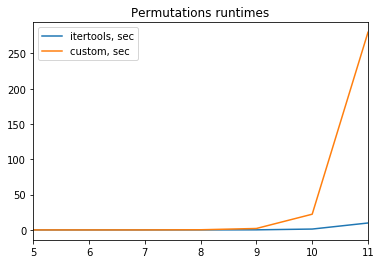

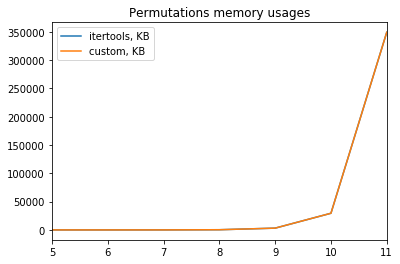

In [37]:
runtimes = {}
memories = {}
for i in tqdm_notebook(range(5,12)):
    item = get_random_string(i)

    start_time = time.time()    
    perms_custom  = list(custom_permutations(item))
    custom = time.time()-start_time
    
    start_time = time.time()
    perms_original  = list(permutations(item))
    original = time.time()-start_time
    
    runtimes[i] = (original, custom)
    memories[i] = (sys.getsizeof(perms_original)/1024, sys.getsizeof(perms_custom)/1024)
    gc.collect()

runtimes = pd.DataFrame.from_dict(runtimes,orient = 'index')    
runtimes.columns = ['itertools, sec','custom, sec']
runtimes.plot()
plt.title('Permutations runtimes')
memories = pd.DataFrame.from_dict(memories,orient = 'index')    
memories.columns = ['itertools, KB','custom, KB']
memories.plot()
plt.title('Permutations memory usages')
plt.show()

#### Комментарий 

Как видим, наша "кастомная" реализация permutations начинает сильно проигрывать по вреемени начиная со строк длиной 9 и более элементов. По памяти различий нет у итогового файла нет.

In [38]:
memories

,"itertools, KB","custom, KB"
5,1.125000,1.125000
6,5.750000,5.750000
7,39.859375,39.859375
8,334.664062,334.664062
9,3139.875000,3139.875000
10,29434.359375,29434.359375
11,349190.515625,349190.515625
